Class name: CS 460g
Assignment: Homework #1
Student Name: Zachary Lippay
Student Number: 10777632

# Import Libraries and Set Data

In [2]:
import numpy as np
import copy
import pandas as pd
import statistics as stat
import matplotlib.pyplot as plt

def gen_from_mean_and_cov(means, covs, labels, mode='train', count=100):
  
  np.random.seed(0) if mode == 'train' else np.random.seed(1)
      
  vals = np.array([]).reshape(0,len(means[0])+1)

  for i, (mean,cov,label) in enumerate(zip(means,covs,labels)):
    vals_new = np.random.multivariate_normal(mean,cov,count);
    vals_new = np.hstack([vals_new,np.ones((vals_new.shape[0],1))*label])
    vals = np.vstack([vals,vals_new])    

  df = pd.DataFrame(data=vals,columns=['x1','x2','y'])

  return df

# There are 6 different simple training datasets

datasets = {
    'train1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0]),
    'train2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1]),
    'train3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0]),
    'train4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0]),
    'train5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0]),
    'train6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1]),
    'test1':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[1,0],mode='test'),
    'test2':gen_from_mean_and_cov([[10,1],[0,4]],[[[2, 0],[0, 2]],[[2, 0],[0, 2]]],[0,1],mode='test'),
    'test3':gen_from_mean_and_cov([[0,1],[0,3.5]],[[[1, .8],[.8, 1]],[[1, .8],[.8, 1]]],[1,0],mode='test'),
    'test4':gen_from_mean_and_cov([[1,0],[3,1]],[[[1, .8],[.8, 1]],[[1, .9],[.9, 1]]],[1,0],mode='test'),
    'test5':gen_from_mean_and_cov([[0,0],[4,0],[-4,0],[0,4],[0,-4]],[[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],[1,0,0,0,0],mode='test'),
    'test6':gen_from_mean_and_cov(
    [[0,0],[4,0],[-4,0],[0,4],[0,-4],[-4,4],[4,4],[4,-4],[-4,-4]],
    [[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]],[[1, 0],[0, 1]]],
    [1,0,0,0,0,1,1,1,1],mode='test')
}



# Training Data, Validation Data,Test Data, and Training Tree

In [8]:

def running_tree_train(train_tree,data_train,k):
    best_score = np.NaN
    split = copy.deepcopy(train_tree)
    
    #! Begin the recursion loop defined by the desired tree depth
    if (k == 0 or data_train.shape[0] < 2 or data_train['y'].drop_duplicates().shape[0] < 2):
        split['label'] = stat.mode(data_train['y'])
    else:
        k = k-1
        for i, curr_feat in enumerate(data_train):
            if curr_feat != 'y':
               
                #! Sort the data such that the current feature values and their corresponding feature values are arranged
                #!       such they are in sequentiial order
                data_train = data_train.sort_values(by=curr_feat).reset_index(drop=True)
                
                for j in range(1,data_train.shape[0]):
                    score = np.empty(2)
                    score.fill(np.NaN)
                    
                    #! Set Threshold
                    curr_thresh = (data_train[curr_feat][j-1] + data_train[curr_feat][j])/2
                    
                    #! Split Data
                    left_data = data_train[data_train[curr_feat] < curr_thresh].reset_index(drop=True)
                    right_data = data_train[data_train[curr_feat] > curr_thresh].reset_index(drop=True)
                    
                    #! Compute the probability of picking a 1 or 0 in each node
                    prob_1_left = np.sum(left_data['y'])/left_data.shape[0]
                    prob_0_left = 1 - prob_1_left
                    score[0] = 1 - np.power(prob_1_left,2) - np.power(prob_0_left,2)
                    prob_1_right = np.sum(right_data['y'])/right_data.shape[0]
                    prob_0_right = 1 - prob_1_right
                    score[1] = 1 - np.power(prob_1_right,2) - np.power(prob_0_right,2)
                
                    #! Determine the best gini score for this data set at the current split
                    if (not best_score < score[0]+score[1]):
                        best_score = score[0] + score[1]
                        des_thresh = curr_thresh
                        thresh_feature = curr_feat
                        node_data_left = left_data
                        node_data_right = right_data                      
            
        split['threshold'] = des_thresh
        split['thresh_feature'] = thresh_feature
        split['score'] = best_score
        split['left'] = running_tree_train(train_tree,node_data_left,k)
        split['right'] = running_tree_train(train_tree,node_data_right,k)
    
    return split



#! Creat the archetecture for the training tree
train_tree = {}
train_tree['threshold'] = np.NaN
train_tree['thresh_feature'] = 0
train_tree['score'] = np.NaN

#! Define the data sets
df = datasets['train1']
test_data = datasets['test1']

#! Split the training data into two sets
train_data = df.sample(frac=0.8,random_state=200)
validation_data = df.drop(train_data.index).reset_index(drop=True)
        
#! Tree depth
tree_depth = 1
              
#! Run the training Tree
trained_tree = running_tree_train(train_tree,train_data,tree_depth)
#print(trained_tree)
print('This tree is done running')

This tree is done running


# Prediction Tree Analysis and Associated Functions

In [9]:
def prediction_tree(trained_tree,test_data,k,split):
    #split={}
    #split['number_correct'] = 0
    if (k == 0 or test_data.shape[0] <= 2):# or test_data['y'].drop_duplicates().shape[0] < 2):
        #print(test_data.shape[0],test_data['y'].drop_duplicates().shape[0])
        #! Compare label of test data versus trained_tree 
        #print(trained_tree)
        split['number_correct'] = split['number_correct'] + test_data[test_data['y'] == trained_tree['label']].shape[0]
    else:
        k = k - 1
        #! Split the test_data per the threshold of the current node of the trained tree
        #print(k,test_data[test_data[trained_tree['thresh_feature']] < trained_tree['threshold']].shape[0])
        #print(test_data[test_data[trained_tree['thresh_feature']]< trained_tree['threshold']])
        left_data = test_data[test_data[trained_tree['thresh_feature']] < trained_tree['threshold']].reset_index(drop=True)
        right_data = test_data[test_data[trained_tree['thresh_feature']] > trained_tree['threshold']].reset_index(drop=True)
        #print(left_data.shape[0])
        if left_data.shape[0] != 0:
            split = prediction_tree(trained_tree['left'],left_data,k,split)
        #print(right_data.shape[0])
        if right_data.shape[0] != 0:
            split = prediction_tree(trained_tree['right'],right_data,k,split)

    return split


def plot_prediction_tree(trained_tree,pict_data,tree_depth):
    score = np.empty(pict_data.shape[0])
    score.fill(np.NaN)
    for i, curr_feat in enumerate(pict_data):
          score[i] = compute_pict_data_class(score[i],tree_depth,curr_feat,trained_tree)
    #print(score)
    return score
    
    
def compute_pict_data_class(score,k,pict_data,trained_tree):
    if (k == 0 or trained_tree['thresh_feature'] == 0):
        score = trained_tree['label']
        #print(score)
    else:
        k = k - 1
        if trained_tree['thresh_feature'] == 'x1':
            if pict_data[0] < trained_tree['threshold']:
                score = compute_pict_data_class(score,k,pict_data,trained_tree['left'])
            else:
                score = compute_pict_data_class(score,k,pict_data,trained_tree['right'])
        else:
            if pict_data[1] < trained_tree['threshold']:
                score = compute_pict_data_class(score,k,pict_data,trained_tree['left'])
            else:
                score = compute_pict_data_class(score,k,pict_data,trained_tree['right'])
    return score
    

#! Allocate space for the split data
split_data = {}
split_data['number_correct'] = 0

#! Determine which set you predicting on
data = test_data#validation_data#

#! Run the prediction tree
prediction_tree(trained_tree,data,tree_depth,split_data)
print('Percent Correct: ', split_data['number_correct']/data.shape[0] )

Percent Correct:  1.0


# Visualize Data

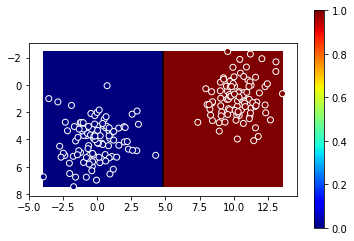

In [10]:
#! This function is basically your source code
def vis2d_classifier(tree,data):
  
  # create the domain for the plot
  x1_min = data.x1.min()
  x1_max = data.x1.max()
  x2_min = data.x2.min()
  x2_max = data.x2.max()

  x1 = np.linspace(x1_min, x1_max, 200)
  x2 = np.linspace(x2_min, x2_max, 200)
  #vis_data = 
  X1,X2 = np.meshgrid(x1, x2)

  # convert it into a matrix (rows are locations, columns are features)
  vis_data = np.hstack([X1.reshape(-1,1),X2.reshape(-1,1)])
  
  # classify each location
  #is_class, vis_sco = predict_tree() #tree_predict(tree,vis_data)
  
  #! This is the new function  
  vis_sco = plot_prediction_tree(trained_tree,vis_data,tree_depth)

  # convert back into image shapes
  #vis_class = vis_class.reshape(X1.shape)
  vis_sco = vis_sco.reshape(X1.shape)

  #
  # Make the plots
  #

  # show the function value in the background
  cs = plt.imshow(vis_sco,
    extent=(x1_min,x1_max,x2_max,x2_min), # define limits of grid, note reversed y axis
    cmap=plt.cm.jet, vmin=0.,vmax=1.)
  plt.clim(0,1) # defines the value to assign the min/max color

  # draw the line on top
  levels = np.array([.5])
  cs_line = plt.contour(X1,X2,vis_sco,levels, colors='k')

  plt.scatter(data.x1,data.x2,c=data.y,edgecolors='w',cmap=plt.get_cmap('jet'))

  # add a color bar
  CB = plt.colorbar(cs)

  plt.show()
  
vis2d_classifier(trained_tree,data)